In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

np.random.seed(42)

In [12]:
noise_list = ['vacuum_cleaner', 'fireworks', 'clapping', 'door_wood_knock', 'washing_machine', 'snoring', 'clock_tick', 'engine', 'mouse_click', 'clock_alarm', 'wind', 'rain', 'breathing', 'laughing', 'keyboard_typing', 'footsteps', 'car_horn', 'drinking_sipping', 'dog', 'toilet_flush']

ESC = pd.read_csv('C:/Users/Anne-Mei/Documents/NTHU/大四上/ML/Final Project/2.datasets/ESC-50/meta/esc50.csv')
mask = ESC['category'].isin(noise_list)
new_ESC = ESC[mask]
new_ESC.shape[0]

800

In [ ]:
def read_datas(clean_file, noise_file, samplerate):
    clean_signal, _ = librosa.load(clean_file, sr=samplerate)
    noise_signal, _ = librosa.load(noise_file, sr=samplerate)
    return clean_signal, noise_signal

def preprocess_noise(clean_signal, noise_signal, samplerate):
    # trim the silent part of the noise data
    noise_signal, _ = librosa.effects.trim(noise_signal)

    # continuous noise: repeat noise to match clean audio length
    if noise_signal.shape[0]/samplerate > 4:
        if noise_signal.shape[0] < clean_signal.shape[0]:
            repeat = int(np.ceil(clean_signal.shape[0]/noise_signal.shape[0]))
            noise_signal = np.tile(noise_signal, repeat)
        new_noise = noise_signal[:clean_signal.shape[0]]
    
    # short noise: add to a random position
    else:
        min_start_time = 1*samplerate
        max_start_time = max(1, clean_signal.shape[0] - noise_signal.shape[0] - 0.5*samplerate)
        if min_start_time > max_start_time:
            min_start_time = 0
        #print(min_start_time, max_start_time, (clean_signal.shape[0] - noise_signal.shape[0] - 0.2*samplerate))
        start_idx = np.random.randint(min_start_time, max_start_time)

        end_idx = start_idx + noise_signal.shape[0]
        if end_idx > clean_signal.shape[0]:
            end_idx = clean_signal.shape[0]
            noise_signal = noise_signal[:end_idx-start_idx]
        
        new_noise = np.zeros_like(clean_signal)
        new_noise[start_idx:end_idx] = noise_signal
    
    return new_noise

def scale_noise(clean_signal, noise_signal, snr):
    # calculate the scaling factor for noise
    clean_power = np.sum(clean_signal ** 2)
    noise_power = np.sum(noise_signal ** 2)
    scaling_factor = np.sqrt(clean_power / (noise_power * 10**(snr/10)))
    return noise_signal * scaling_factor

def mix_data(clean_signal, noise_signal):
    mixed_signal = clean_signal + noise_signal
    mixed_signal = np.clip(mixed_signal, -1.0, 1.0)
    return mixed_signal

In [9]:
clean_path = 'E:/ML_final_project/test/clean_speech/'
noise_path = 'C:/Users/Anne-Mei/Documents/NTHU/大四上/ML/Final Project/2.datasets/ESC-50/audio/'
output_path = 'E:/ML_final_project/test/noisy_speech/'
clean_files = [os.path.join(clean_path,f) for f in os.listdir(clean_path) if f.endswith('.mp3')]
noise_files = [os.path.join(noise_path,f) for f in new_ESC['filename'].tolist()]
#noise_files = [os.path.join(noise_path,f) for f in os.listdir(noise_path) if f.endswith('.wav')]

# randomly select a noise and SNR for each clean speech data
noise_idx = np.random.choice(len(noise_files), size=len(clean_files), replace=True)
SNRs = np.random.choice([0, 5, 10, 15], size=len(clean_files), replace=True)
#print(noise_idx)
#print(SNRs)
#print(np.unique(SNRs, return_counts=True))

samplerate = 16000
for i, clean_file in enumerate(clean_files):

    # load and resample data
    clean_signal, noise_signal = read_datas(clean_file, noise_files[noise_idx[i]], samplerate)
    # pre-process noise data
    noise_signal = preprocess_noise(clean_signal, noise_signal, samplerate)
    # scale the noise data
    scaled_noise = scale_noise(clean_signal, noise_signal, SNRs[i])
    # mix the noise into the clean speech
    mixed_signal = mix_data(clean_signal, scaled_noise)

    clean_id = os.path.basename(clean_file).replace('common_voice_zh-TW_', '').replace('_filtered.mp3', '')
    noise_id = os.path.basename(noise_files[noise_idx[i]]).replace('.wav', '')
    output_file = output_path + clean_id + '_' + noise_id + '.mp3'
    sf.write(output_file, mixed_signal, samplerate)

    if i % 1000 == 0:
        print("i=", i)


i= 0


### Test

In [150]:
def plot_time_domain(clean_signal, noise_signal, mixed_signal, sr):
    
    plt.figure(figsize=(12,8))
    y_limit = [clean_signal.min(), clean_signal.max()]

    # clean speech
    plt.subplot(311)
    librosa.display.waveshow(clean_signal, sr=sr)
    plt.title('Clean Speech')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim(y_limit)

    # noise audio
    plt.subplot(312)
    librosa.display.waveshow(noise_signal, sr=sr)
    plt.title('Noise')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim(y_limit)

    # mixed speech
    plt.subplot(313)
    librosa.display.waveshow(mixed_signal, sr=sr)
    plt.title('Noisy Speech')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim(y_limit)

    plt.tight_layout()
    plt.show()

In [159]:
def plot_spectrogram(clean_signal, noise_signal, mixed_signal, sr):
    
    D_clean = librosa.stft(clean_signal)
    D_noise = librosa.stft(noise_signal)
    D_mixed = librosa.stft(mixed_signal)
    D_clean_db = librosa.amplitude_to_db(np.abs(D_clean), ref=np.max)
    D_noise_db = librosa.amplitude_to_db(np.abs(D_noise), ref=np.max)
    D_mixed_db = librosa.amplitude_to_db(np.abs(D_mixed), ref=np.max)

    plt.figure(figsize=(12,8))

    # clean speech
    plt.subplot(311)
    librosa.display.specshow(D_clean_db, x_axis='time', y_axis='log', sr=sr)
    plt.title('Clean Speech STFT')
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel('Frequency (Hz)')

    # noise audio
    plt.subplot(312)
    librosa.display.specshow(D_noise_db, x_axis='time', y_axis='log', sr=sr)
    plt.title('Noise STFT')
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel('Frequency (Hz)')

    # mixed speech
    plt.subplot(313)
    librosa.display.specshow(D_mixed_db, x_axis='time', y_axis='log', sr=sr)
    plt.title('Noisy Speech STFT')
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()

#### dog

In [151]:
clean_file = 'E:/ML_final_project/test2/clean_speech/common_voice_zh-TW_17367893_filtered.mp3'
noise_file = 'E:/ML_final_project/test2/noise/1-100032-A-0-dog.wav'
samplerate = 16000
snr = 15

# load and resample data
clean_signal, noise_signal = read_datas(clean_file, noise_file, samplerate)
# pre-process noise data
noise_signal = preprocess_noise(clean_signal, noise_signal, samplerate)
# scale the noise data
scaled_noise = scale_noise(clean_signal, noise_signal, snr)
# mix the noise into the clean speech
mixed_signal = mix_data(clean_signal, scaled_noise)

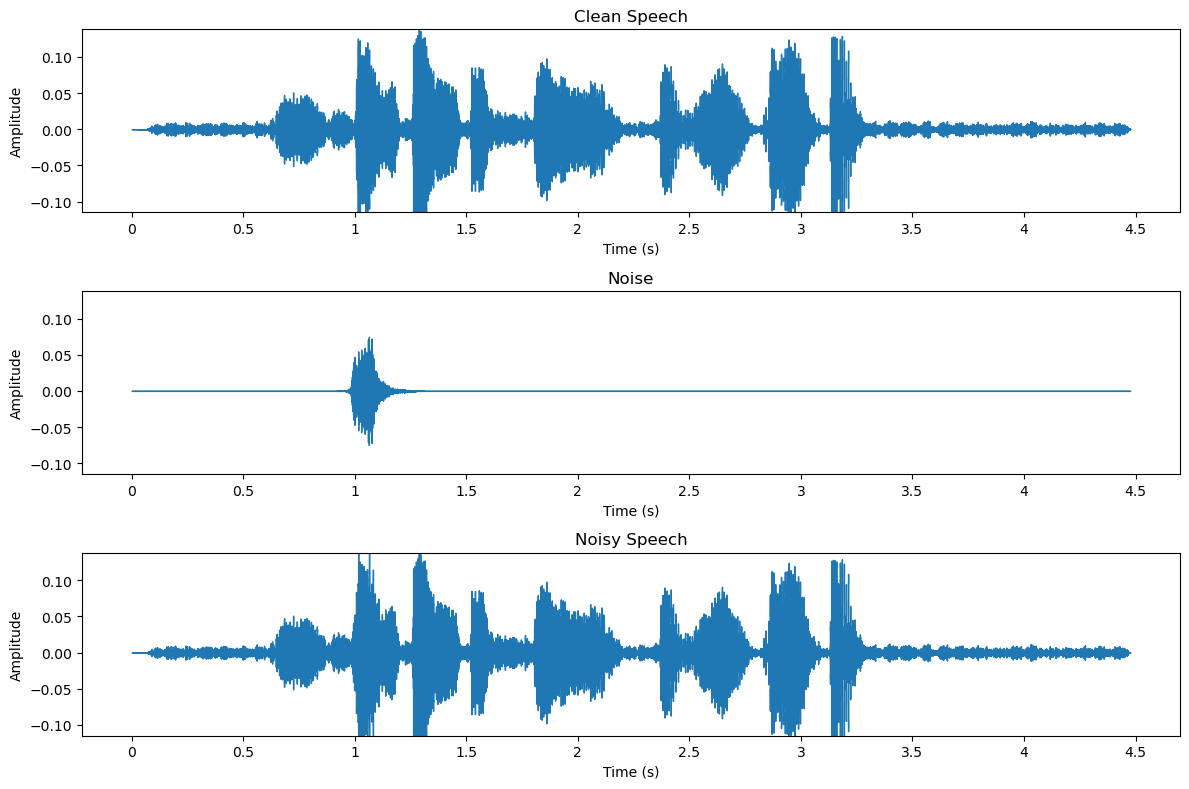

In [152]:
plot_time_domain(clean_signal, scaled_noise, mixed_signal, samplerate)

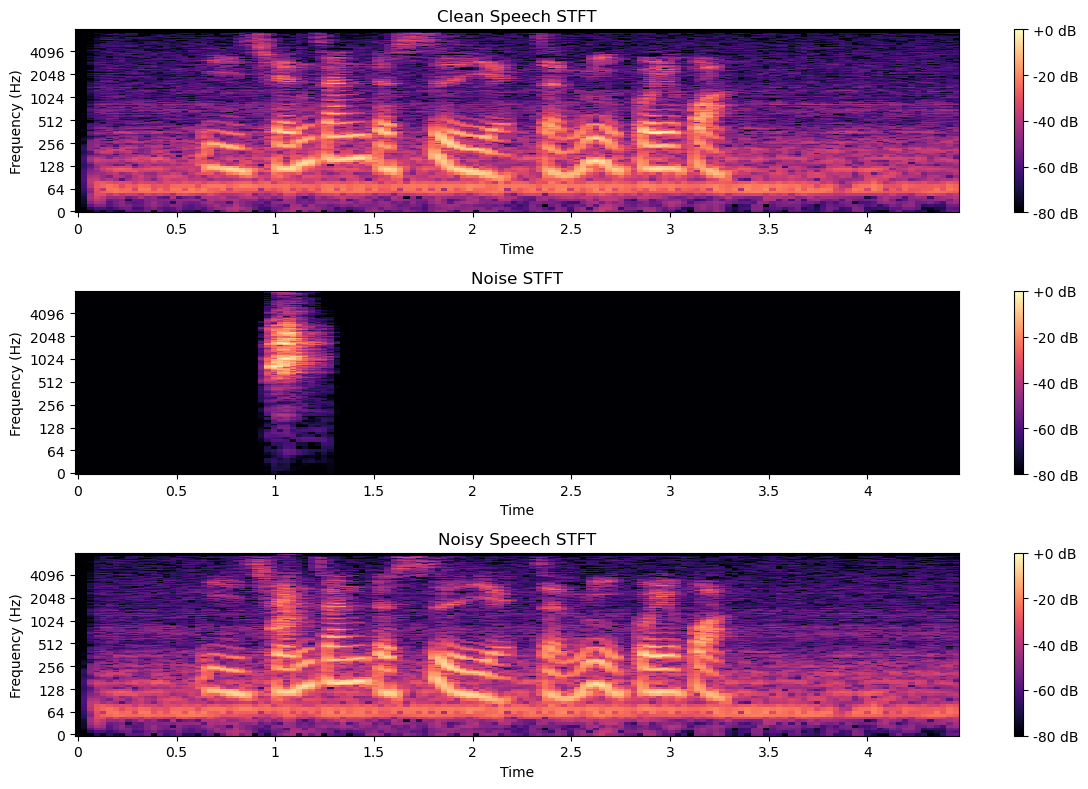

In [153]:
plot_spectrogram(clean_signal, noise_signal, mixed_signal, samplerate)

#### Vacuum Cleaner

In [154]:
clean_file = 'E:/ML_final_project/test2/clean_speech/common_voice_zh-TW_17368081_filtered.mp3'
noise_file = 'E:/ML_final_project/test2/noise/1-100210-A-36-vacuum_cleaner.wav'
samplerate = 16000
snr = 10

# load and resample data
clean_signal, noise_signal = read_datas(clean_file, noise_file, samplerate)
# pre-process noise data
noise_signal = preprocess_noise(clean_signal, noise_signal, samplerate)
# scale the noise data
scaled_noise = scale_noise(clean_signal, noise_signal, snr)
# mix the noise into the clean speech
mixed_signal = mix_data(clean_signal, scaled_noise)

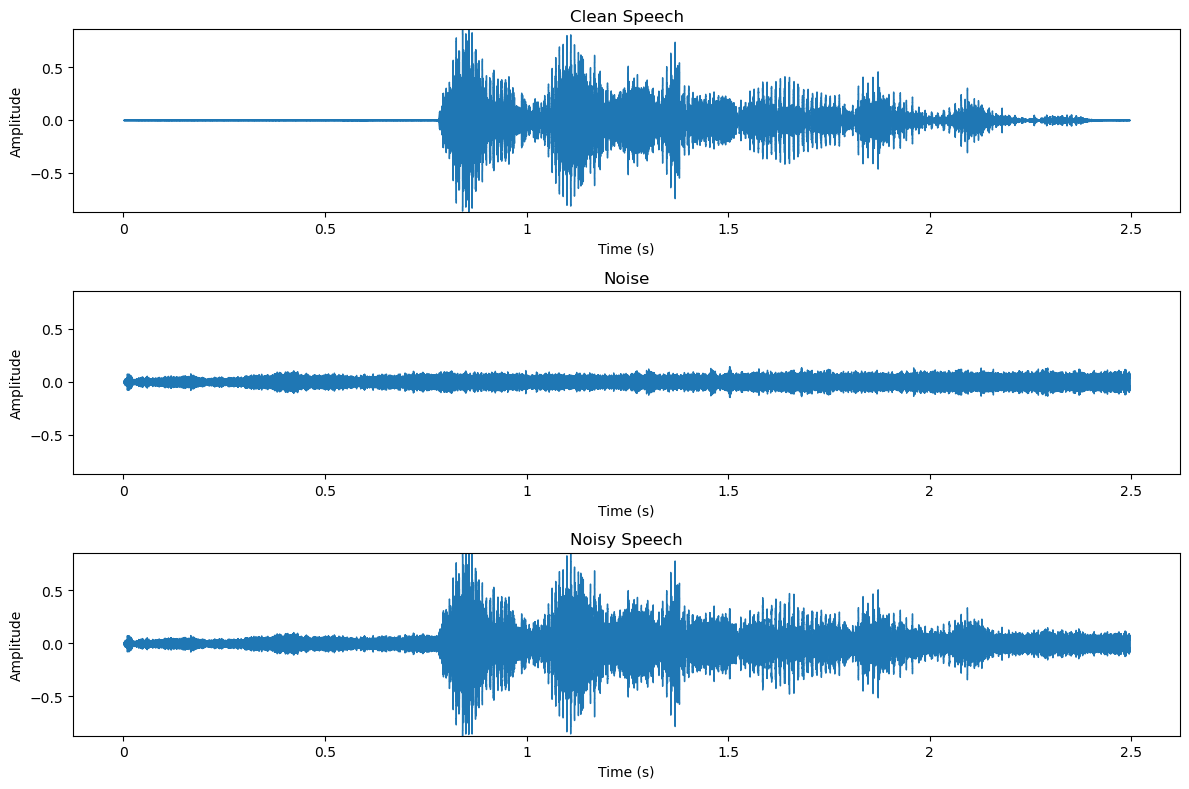

In [155]:
plot_time_domain(clean_signal, scaled_noise, mixed_signal, samplerate)

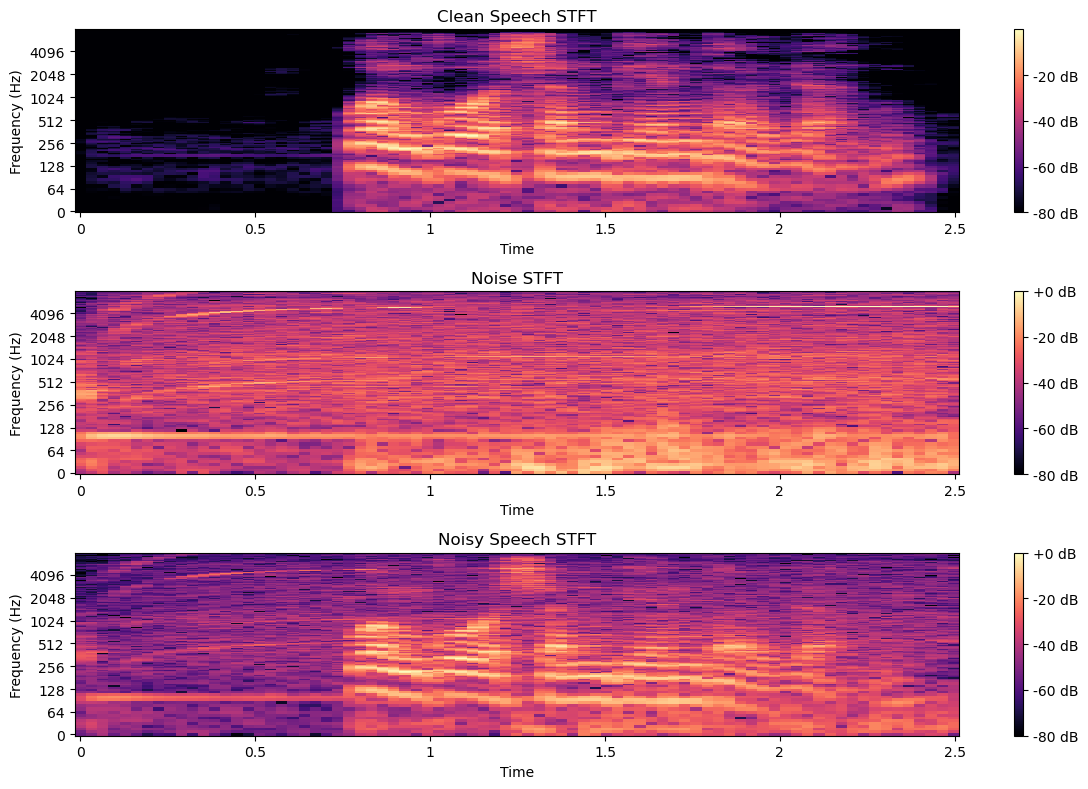

In [156]:
plot_spectrogram(clean_signal, noise_signal, mixed_signal, samplerate)

#### Fireworks

In [169]:
clean_file = 'E:/ML_final_project/test2/clean_speech/common_voice_zh-TW_17367905_filtered.mp3'
noise_file = 'E:/ML_final_project/test2/noise/1-160563-A-48-fireworks.wav'
samplerate = 16000
snr = 10

# load and resample data
clean_signal, noise_signal = read_datas(clean_file, noise_file, samplerate)
# pre-process noise data
noise_signal = preprocess_noise(clean_signal, noise_signal, samplerate)
# scale the noise data
scaled_noise = scale_noise(clean_signal, noise_signal, snr)
# mix the noise into the clean speech
mixed_signal = mix_data(clean_signal, scaled_noise)

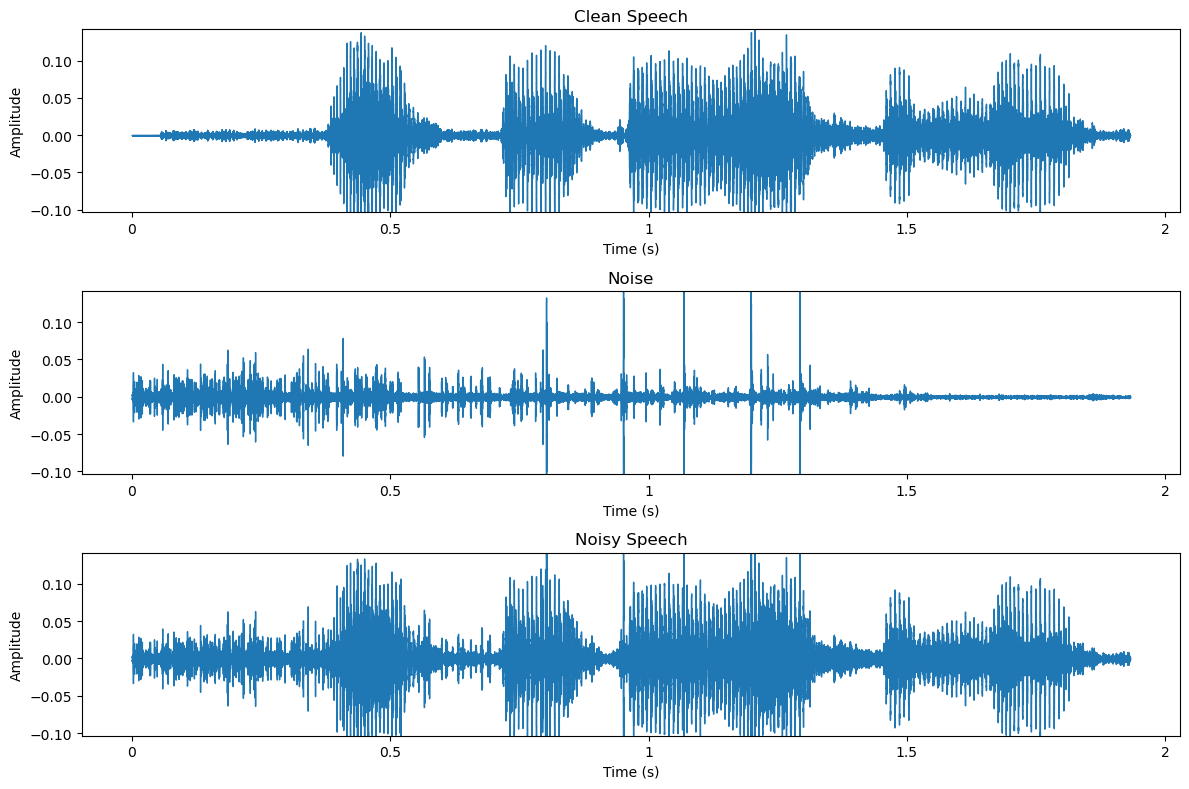

In [170]:
plot_time_domain(clean_signal, scaled_noise, mixed_signal, samplerate)

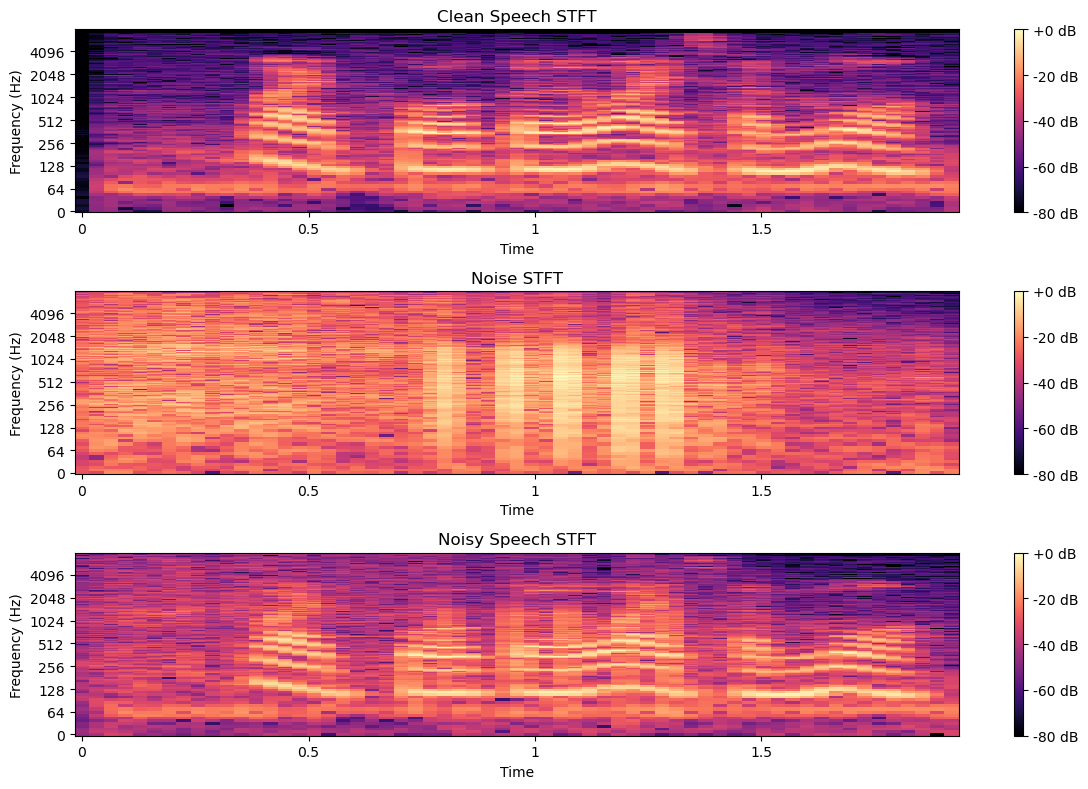

In [171]:
plot_spectrogram(clean_signal, noise_signal, mixed_signal, samplerate)